In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split 
import random

In [3]:
#step1/7 设置随机数种子
def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     random.seed(seed)
     torch.backends.cudnn.deterministic = True
     
setup_seed(2)
    
#step 2/7 划分训练集和测试集
data = np.loadtxt('./Data/News3.csv', delimiter=',', dtype=np.float32,skiprows = 1)

x=torch.from_numpy(data[:,1:-2]).cuda()
y=torch.from_numpy(data[:,[-1]]).cuda()

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=1)

In [279]:
#step 3/7 模型构建
class LR(nn.Module):
    #调用nn.Module模块构建LR模型
    def __init__(self):
        super(LR, self).__init__()
        self.linear1= nn.Linear(25,50)
        self.linear2= nn.Linear(50,4)
        self.linear3= nn.Linear(4,1)
        self.sigmoid= nn.Sigmoid()
        
    def forward(self,x):#确定函数模型
        x = self.sigmoid(self.linear1(x))
        x = self.sigmoid(self.linear2(x))
        x = self.sigmoid(self.linear3(x))
        return x


In [13]:
cudaMsg = torch.cuda.is_available()
lr_net=LR().cuda() #实例化模型并将其移至GPU

In [295]:
# step4/7 利用focal loss构造损失函数

class FocalLoss(nn.Module):
    def __init__(self,alpha=0.05,gamma=2):
        super(FocalLoss,self).__init__()
        self.alpha=alpha
        self.gamma=gamma
    def forward(self,y_pred,y_train):
        eps=1e-7
        loss_1=-1*self.alpha*torch.pow((1-y_pred),self.gamma)*torch.log(y_pred+eps)*y_train
        loss_0=-1*(1-self.alpha)*torch.pow(y_pred,self.gamma)*torch.log(1-y_pred+eps)*(1-y_train)
        loss=loss_0+loss_1
        return torch.mean(loss)
    

       
loss_fn=FocalLoss(alpha=0.04973157894736842)

loss_fn2 = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([0.06])).cuda()

# weights = torch.FloatTensor([9,1])
# criterion = nn.BCEWithLogitsLoss(pos_weight=weights).cuda()

0 0.01659291237592697
1 0.016592441126704216
2 0.016591548919677734
3 0.016590284183621407
4 0.016588686034083366
5 0.016586799174547195
6 0.01658465713262558
7 0.016582295298576355
8 0.016579745337367058
9 0.016577038913965225
10 0.016574198380112648
11 0.016571244224905968
12 0.016568198800086975
13 0.016565078869462013
14 0.016561899334192276
15 0.016558675095438957
16 0.016555417329072952
17 0.016552140936255455
18 0.016548849642276764
19 0.016545556485652924
20 0.01654227077960968
21 0.01653899997472763
22 0.016535747796297073
23 0.016532523557543755
24 0.016529325395822525
25 0.01652616262435913
26 0.01652303710579872
27 0.016519952565431595
28 0.0165169108659029
29 0.01651391200721264
30 0.016510963439941406
31 0.016508061438798904
32 0.016505209729075432
33 0.01650240831077099
34 0.016499657183885574
35 0.016496960073709488
36 0.01649431139230728
37 0.016491718590259552
38 0.016489176079630852
39 0.01648668386042118
40 0.016484245657920837
41 0.016481859609484673
42 0.016479523

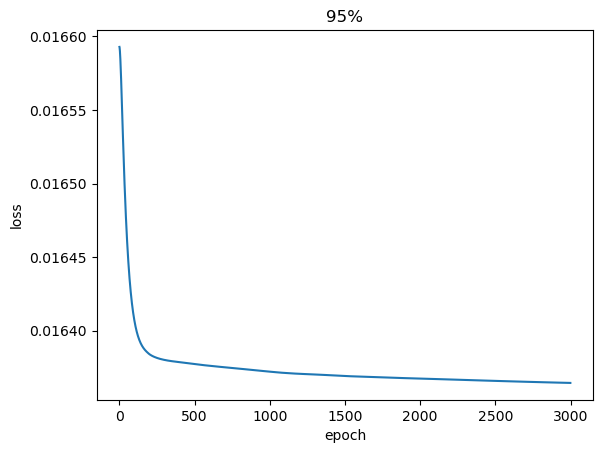

In [296]:
#step 5/7 选择优化器
lr_net=LR().cuda() #实例化模型并将其移至GPU
lr=0.01 #学习率
optimizer=torch.optim.SGD(lr_net.parameters(),lr=lr,momentum=0.9)

#step 6/7 模型训练
import torch.nn.functional as F
px,py=[],[]


for epoch in range(3000):
    y_pred=lr_net(x_train)
    loss=loss_fn(y_pred,y_train)
    print(epoch,loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    px.append(epoch)
    py.append(loss.item())
    
plt.plot(px,py)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title('95%')
plt.show()


In [297]:

#step 7/7 测试及可视化展示

y_pred_test=lr_net(x_test)
loss_test=loss_fn(y_pred_test,y_test)


y_pred01=y_pred_test.tolist()
y_test01=y_test.tolist()
y_pred02=[]
y_test02=[]
for i in y_pred01:
    if i[0]<0.5:
        y_pred02.append(0)
    else:
        y_pred02.append(1)
for j in y_test01:
    if j[0]<0.5:
        y_test02.append(0)
    else:
        y_test02.append(1)


0.9493670886075949
0.22408026755852842
roc_auc: 0.504519991118339 0.504519991118339


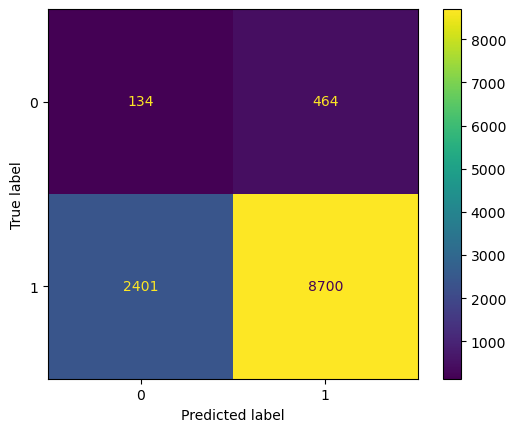

In [298]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm=confusion_matrix(y_test02,y_pred02)
cm_display=ConfusionMatrixDisplay(cm).plot()
print(precision_score(y_test02,y_pred02))
print(recall_score(y_test02, y_pred02, pos_label=0))


from sklearn.metrics import roc_curve,auc

y_pred_test = lr_net(x_test)
y_pred_proba = y_pred_test.detach().cpu().numpy()
auc_score = roc_auc_score(y_test02, y_pred_proba)

fpr, tpr, threshold = roc_curve(y_test02, y_pred_proba)

roc_auc = auc(fpr,tpr)   # 准确率代表所有正确的占所有数据的比值
print('roc_auc:', auc_score, roc_auc)


# lw = 2
# plt.subplot(1,1,1)
# plt.plot(fpr, tpr, color='darkorange',
#          lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)  # 假正率为横坐标，真正率为纵坐标做曲线
# plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.0])
# plt.xlabel('1 - specificity')
# plt.ylabel('Sensitivity')
# plt.title('ROC', y=0.5)
# plt.legend(loc="lower right")
# plt.show()

In [299]:
y_pred_proba

array([[0.5001032 ],
       [0.49878928],
       [0.5001032 ],
       ...,
       [0.5001032 ],
       [0.5001032 ],
       [0.5001032 ]], dtype=float32)

In [293]:
# 根据AUC值寻找最优alpha和gamma值的过程
from sklearn.metrics import roc_auc_score

best_auc = 0
best_alpha = 0
best_gamma = 0

alpha_values = np.linspace(0.0497,0.0498,20)
# gamma_values = np.linspace(0.1, 5, 10)

In [294]:
for alpha in alpha_values:
    gamma = 2
    print(f"{alpha}:Begin")
    lr_net=LR().cuda() #实例化模型
    loss_fn = FocalLoss(alpha=alpha, gamma=gamma).cuda()
    optimizer = torch.optim.SGD(lr_net.parameters(), lr=lr, momentum=0.9)

    for epoch in range(3000):
        y_pred = lr_net(x_train)
        loss = loss_fn(y_pred, y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    y_pred_test = lr_net(x_test)
    y_pred_proba = y_pred_test.detach().cpu().numpy()
    auc_score = roc_auc_score(y_test02, y_pred_proba)

    if auc_score > best_auc:
        best_auc = auc_score
        best_alpha = alpha
        best_gamma = gamma

print("最优alpha值：", best_alpha)
print("最优gamma值：", best_gamma)
print("最优AUC值：", best_auc)

# 使用最优的alpha和gamma值重新训练模型
loss_fn = FocalLoss(alpha=best_alpha, gamma=best_gamma)
optimizer = torch.optim.SGD(lr_net.parameters(), lr=lr, momentum=0.9)

for epoch in range(300):
    y_pred = lr_net(x_train)
    loss = loss_fn(y_pred, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


0.0497:Begin
0.04970526315789474:Begin
0.049710526315789476:Begin
0.04971578947368421:Begin
0.04972105263157895:Begin
0.04972631578947368:Begin
0.04973157894736842:Begin
0.049736842105263156:Begin
0.04974210526315789:Begin
0.04974736842105263:Begin
0.04975263157894737:Begin
0.049757894736842105:Begin
0.04976315789473684:Begin
0.04976842105263158:Begin
0.04977368421052632:Begin
0.04977894736842105:Begin
0.049784210526315785:Begin
0.04978947368421052:Begin
0.04979473684210526:Begin
0.0498:Begin
最优alpha值： 0.04973157894736842
最优gamma值： 2
最优AUC值： 0.5271720677187478
